# Lorenz 63

In [1]:
import autoroot  # noqa: F401, I001
import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from oi_toolz._src.models.l63 import L63Params, L63State, l63_equation_of_motion

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Simulations

In [2]:
u0 = L63State(x=1,y=1,z=1)
params = L63Params(sigma=10.0, beta=8.0/3.0, rho=28.0)

In [27]:
u0.y.shape

()

### Warmup

In [3]:
dt0 = 0.01
t0 = 0
t1 = 10
t_steps = int(t1/dt0)

ts = np.linspace(0, t1, t_steps + 1)

In [28]:
dt0

0.01

In [4]:
saveat = dfx.SaveAt(ts=ts)
stepsize_controller = dfx.PIDController(rtol=1e-7, atol=1e-7)
solver = dfx.Tsit5()

In [5]:
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(l63_equation_of_motion),
    t0=t0,
    t1=t1,
    dt0=dt0,
    y0=u0,
    args=params,
    saveat=saveat,
    solver=solver,
    stepsize_controller=stepsize_controller,
)

In [6]:
u0 = L63State(x=sol.ys.x[-1], y=sol.ys.y[-1], z=sol.ys.z[-1])

In [7]:
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(l63_equation_of_motion),
    t0=t0,
    t1=t1,
    dt0=dt0,
    y0=u0,
    args=params,
    saveat=saveat,
    solver=solver,
    stepsize_controller=stepsize_controller,
)

In [8]:
ds_sol = xr.Dataset(
    {
        "x": (("time"), sol.ys.x.squeeze()),
        "y": (("time"), sol.ys.y.squeeze()),
        "z": (("time"), sol.ys.z.squeeze()),
    },
    coords={
        "time": (["time"], sol.ts.squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": np.asarray(params.sigma),
        "beta": np.asarray(params.beta),
        "rho": np.asarray(params.rho),
    },
)

ds_sol

<xarray.Dataset>
Dimensions:  (time: 1001)
Coordinates:
  * time     (time) float32 0.0 0.01 0.02 0.03 0.04 ... 9.96 9.97 9.98 9.99 10.0
Data variables:
    x        (time) float32 -4.903 -4.799 -4.718 -4.661 ... 13.72 13.77 13.74
    y        (time) float32 -3.744 -3.878 -4.028 -4.196 ... 14.77 13.89 12.88
    z        (time) float32 24.69 24.22 23.77 23.34 ... 31.63 32.83 33.92 34.84
Attributes:
    ode:      lorenz_63
    sigma:    10.0
    beta:     2.6666667
    rho:      28.0

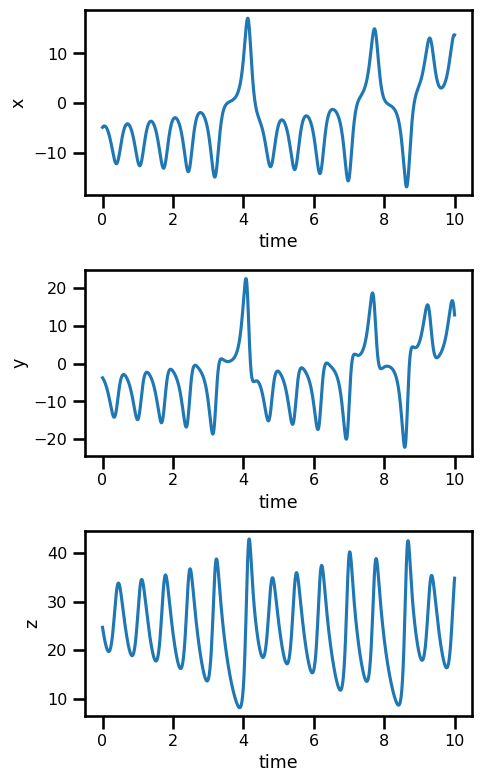

In [9]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

ds_sol.x.plot(ax=ax[0])
ds_sol.y.plot(ax=ax[1])
ds_sol.z.plot(ax=ax[2])

plt.tight_layout()
plt.show()

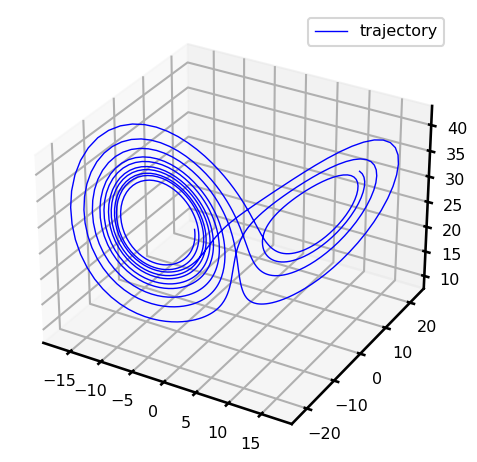

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(ds_sol.x, ds_sol.y, ds_sol.z, lw=1.0, color="blue", label="trajectory")
ax
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
ds_sol = ds_sol.to_array(dim="component", name="simulation").to_dataset()
ds_sol

<xarray.Dataset>
Dimensions:     (time: 1001, component: 3)
Coordinates:
  * time        (time) float32 0.0 0.01 0.02 0.03 0.04 ... 9.97 9.98 9.99 10.0
  * component   (component) object 'x' 'y' 'z'
Data variables:
    simulation  (component, time) float32 -4.903 -4.799 -4.718 ... 33.92 34.84

##  Missing Data

In [12]:
dt_obs = 0.2
t_max_obs = 2
t_steps_obs = int(t_max_obs/dt_obs)

In [13]:
ind_obs = np.linspace(int(dt_obs/dt0), int(t_max_obs/dt0), t_steps_obs).astype(int)
t_obs = ts[ind_obs]
t_obs

array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])

In [14]:
ds_sol["observations"] = xr.full_like(ds_sol.simulation, np.nan)

In [15]:
ds_sol["simulation"][0, ind_obs]

<xarray.DataArray 'simulation' (time: 10)>
array([ -6.7560806, -12.231695 ,  -5.5672345,  -5.029505 , -11.663461 ,
        -7.5909534,  -3.716074 ,  -8.627912 , -11.488653 ,  -3.3432484],
      dtype=float32)
Coordinates:
  * time       (time) float32 0.2 0.4 0.6 0.8 1.0 1.2 1.4 1.6 1.8 2.0
    component  <U1 'x'
Attributes:
    ode:      lorenz_63
    sigma:    10.0
    beta:     2.6666667
    rho:      28.0

In [16]:
ds_sol["observations"][:, ind_obs] = ds_sol["simulation"][:, ind_obs]

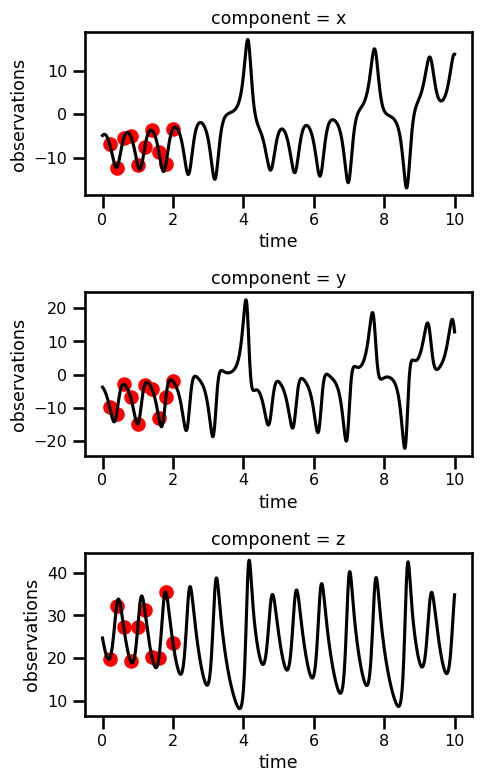

In [17]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

ds_sol.simulation.sel(component="x").plot(ax=ax[0], color="black")
ds_sol.simulation.sel(component="y").plot(ax=ax[1], color="black")
ds_sol.simulation.sel(component="z").plot(ax=ax[2], color="black")
ds_sol.observations.sel(component="x").plot.scatter(ax=ax[0], color="red")
ds_sol.observations.sel(component="y").plot.scatter(ax=ax[1], color="red")
ds_sol.observations.sel(component="z").plot.scatter(ax=ax[2], color="red")

plt.tight_layout()
plt.show()

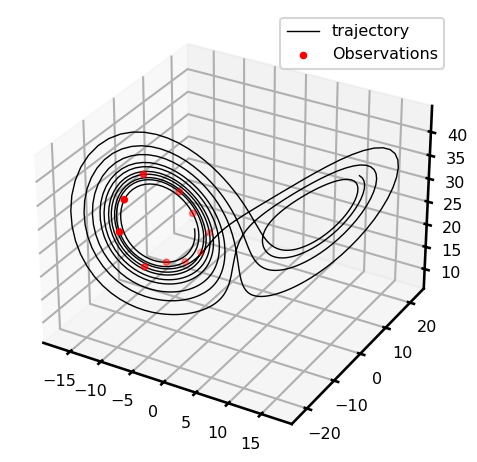

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(
    ds_sol.simulation.sel(component="x"), 
    ds_sol.simulation.sel(component="y"),
    ds_sol.simulation.sel(component="z"),
    lw=1.0, color="black", label="trajectory"
)
ax.scatter(
    ds_sol.observations.sel(component="x"), 
    ds_sol.observations.sel(component="y"),
    ds_sol.observations.sel(component="z"),
    lw=1.0, color="red", label="Observations"
)

plt.legend()
plt.tight_layout()
plt.show()


## Noise

In [19]:
rng = np.random.RandomState(123)
sigma_y = 0.15

noise =  sigma_y**2 * rng.randn(*ds_sol["observations"].shape)

ds_sol["observations_noisy"] = ds_sol["observations"] + noise

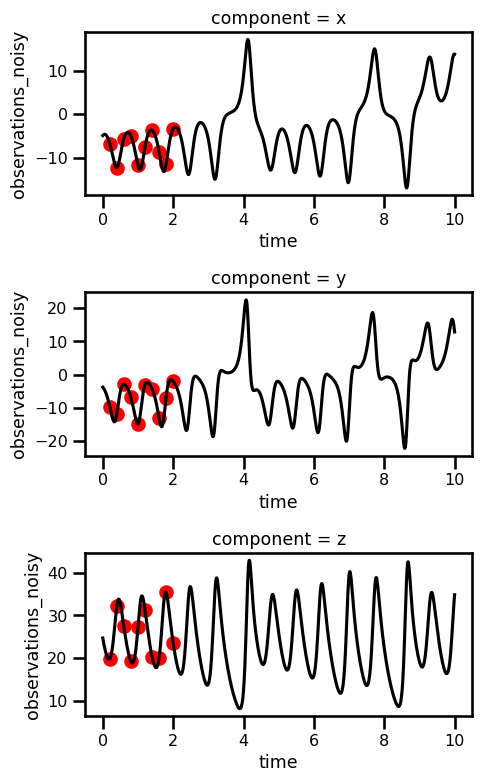

In [20]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

ds_sol.simulation.sel(component="x").plot(ax=ax[0], color="black")
ds_sol.simulation.sel(component="y").plot(ax=ax[1], color="black")
ds_sol.simulation.sel(component="z").plot(ax=ax[2], color="black")
ds_sol.observations_noisy.sel(component="x").plot.scatter(ax=ax[0], color="red")
ds_sol.observations_noisy.sel(component="y").plot.scatter(ax=ax[1], color="red")
ds_sol.observations_noisy.sel(component="z").plot.scatter(ax=ax[2], color="red")

plt.tight_layout()
plt.show()

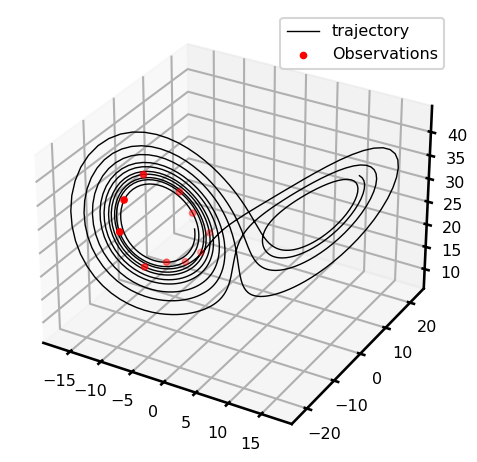

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(
    ds_sol.simulation.sel(component="x"), 
    ds_sol.simulation.sel(component="y"),
    ds_sol.simulation.sel(component="z"),
    lw=1.0, color="black", label="trajectory"
)
ax.scatter(
    ds_sol.observations_noisy.sel(component="x"), 
    ds_sol.observations_noisy.sel(component="y"),
    ds_sol.observations_noisy.sel(component="z"),
    lw=1.0, color="red", label="Observations"
)

plt.legend()
plt.tight_layout()
plt.show()


In [22]:
ds_sol.to_netcdf("/Users/eman/code_projects/data/pyda/lorenz63/l63_sim.nc", engine="netcdf4")